# Kaggle / Sébastien PAVOT

## https://www.kaggle.com/c/mbd2019-in-class-competition-bank-mkt

## Libraries:

In [13]:
library(data.table)
library(ggplot2)
library(caret)
library(randomForest)
library(e1071) 
library(dplyr)
library(woeBinning)
library(varhandle)
library(tidyverse)
library(ISLR)
library(leaps)
library(Boruta)
library(mlr)
library(kernlab)
library(boot)
library(DiscriMiner)
library(earth)
library(adabag)
library(party)
library(C50)
library(klaR)

Warning message:
"package 'data.table' was built under R version 3.6.1"Warning message:
"package 'ggplot2' was built under R version 3.6.2"Warning message:
"package 'caret' was built under R version 3.6.2"Loading required package: lattice
randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.

Attaching package: 'randomForest'

The following object is masked from 'package:ggplot2':

    margin

Warning message:
"package 'e1071' was built under R version 3.6.2"Warning message:
"package 'dplyr' was built under R version 3.6.2"
Attaching package: 'dplyr'

The following object is masked from 'package:randomForest':

    combine

The following objects are masked from 'package:data.table':

    between, first, last

The following objects are masked from 'package:stats':

    filter, lag

The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union

Warning message:
"package 'varhandle' was built under R version 3.6.2"Warning message:
"packa

## Data importation:

In [39]:
data = "C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/"

In [40]:
DataSet = read.csv(paste(data,"bank_mkt_train.csv", sep =""))

In [41]:
PredictSet = read.csv(paste(data,"bank_mkt_test.csv", sep =""))

# Part 1: Data Processing, engineering and transformation:

## Data processing:

#### Check for missing values:

In [6]:
for (i in names(DataSet)){
    print(i)
    print(sum(is.na(DataSet[[i]])))
}

[1] "client_id"
[1] 0
[1] "age"
[1] 0
[1] "job"
[1] 0
[1] "marital"
[1] 0
[1] "education"
[1] 0
[1] "default"
[1] 0
[1] "housing"
[1] 0
[1] "loan"
[1] 0
[1] "contact"
[1] 0
[1] "month"
[1] 0
[1] "day_of_week"
[1] 0
[1] "campaign"
[1] 0
[1] "pdays"
[1] 0
[1] "previous"
[1] 0
[1] "poutcome"
[1] 0
[1] "emp.var.rate"
[1] 0
[1] "cons.price.idx"
[1] 0
[1] "cons.conf.idx"
[1] 0
[1] "euribor3m"
[1] 0
[1] "nr.employed"
[1] 0
[1] "subscribe"
[1] 0


No missing values in any column.

#### Check the structure of the Data:

In [7]:
str(DataSet)

'data.frame':	7000 obs. of  21 variables:
 $ client_id     : int  2 3 4 5 6 7 8 9 14 15 ...
 $ age           : int  29 39 49 32 29 51 34 52 52 29 ...
 $ job           : Factor w/ 12 levels "admin.","blue-collar",..: 4 11 2 7 1 7 2 8 1 1 ...
 $ marital       : Factor w/ 4 levels "divorced","married",..: 3 2 2 3 3 2 2 2 2 3 ...
 $ education     : Factor w/ 8 levels "basic.4y","basic.6y",..: 4 3 2 7 4 7 1 4 7 7 ...
 $ default       : Factor w/ 2 levels "no","unknown": 1 2 2 1 2 2 1 1 1 1 ...
 $ housing       : Factor w/ 3 levels "no","unknown",..: 1 3 1 3 3 3 3 3 3 3 ...
 $ loan          : Factor w/ 3 levels "no","unknown",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ contact       : Factor w/ 2 levels "cellular","telephone": 2 2 1 1 1 2 1 1 1 1 ...
 $ month         : Factor w/ 10 levels "apr","aug","dec",..: 7 5 8 7 4 5 8 8 8 5 ...
 $ day_of_week   : Factor w/ 5 levels "fri","mon","thu",..: 2 1 4 2 1 4 4 4 3 2 ...
 $ campaign      : int  3 6 2 3 2 1 1 1 3 1 ...
 $ pdays         : int  999 999 999 999 9

We can see that we don't need to change any data type for now, they look already in the right format.

### Analyze the distribution of the dependent variable:

In [8]:
table(DataSet$subscribe)


   0    1 
6178  822 

In [9]:
(6178 / (6178 +822))

[1] 0.8825714

We can see that 88% of the customer didn't subscribe so we will use the AUC instead of accuracy as our metrics since predictiing all people as non suscriber would already lead to 88% of accuracy.

## Features engineering:

We will now transform some variables in more meaningful variables by processing with feature engineering techniques.

#### Age:

In [42]:
quantile(DataSet$age, probs = seq(0,1, 0.20))

0%  20%  40%  60%  80% 100% 
  18   31   36   42   50   98

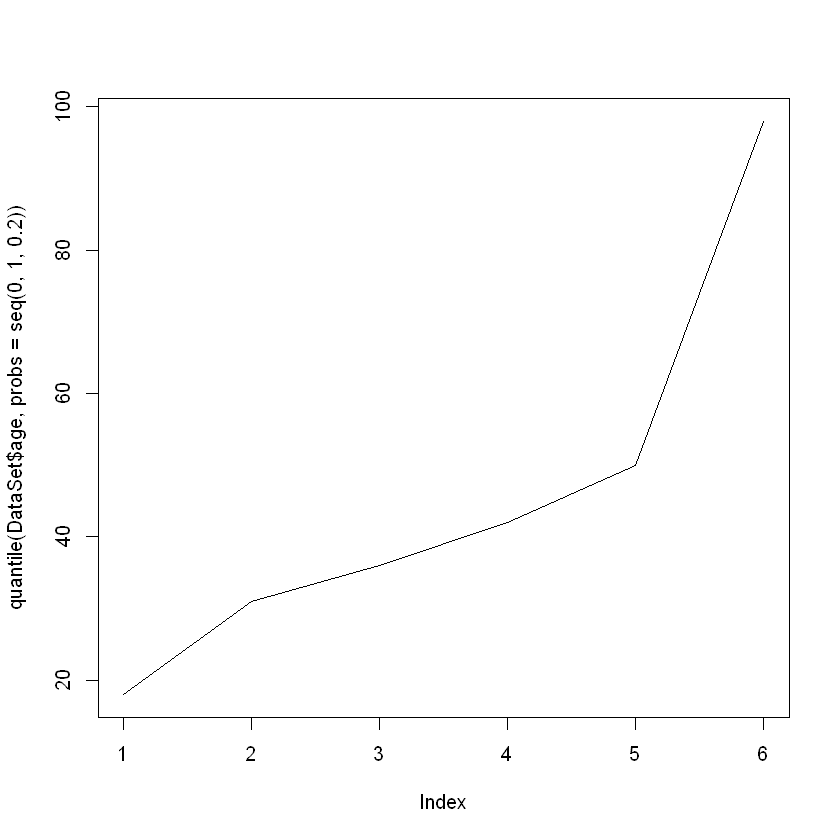

In [43]:
plot(quantile(DataSet$age, probs = seq(0,1, 0.20)), type = "l")

Regarding the plot, we can define a new variables based on age and using the quantile to group the age in 5 categories. First group will be 0 - 31yo, second 31-36yo, third 36-42yo, fourth 42-50yo, fifth 50 - max(age).

In [12]:
#We create a function to easily apply this to the dataset & the predict set:
agegrouped = function(data){
    data$age_supervised_bin = "1stQuantile"
    data[data$age >= 31 & data$age <= 36,]$age_supervised_bin = "2ndQuantile"
    data[data$age > 36 & data$age <= 42,]$age_supervised_bin = "3rdQuantile"
    data[data$age > 42 & data$age <= 50,]$age_supervised_bin = "4thQuantile"
    data[data$age > 50,]$age_supervised_bin = "5thQuantile"
    data$age_supervised_bin = as.factor(data$age_supervised_bin)
}

DataSet$age_supervised_bin = NA
DataSet$age_supervised_bin = agegrouped(DataSet)

PredictSet$age_supervised_bin = NA
PredictSet$age_supervised_bin = agegrouped(PredictSet)


#### Pdays:

In [13]:
table(DataSet$pdays)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
   2    2   14   77   13    6   79    7    1   10   13    4    7   10    1    4 
  16   17   18   19   21   22  999 
   2    1    2    2    1    1 6741 

We can see that pdays is a numeric variable with value between 0 to 22 but we have a lot of value as 999 which we can think it's a value to identify a specific type of pdays. Thus, we have to create a new variable to identify when the value are 999 because else the alogorithm will think that 999 is a value which is way higher than the other one and the difference between 0 to 22 are going to be reduce a lot and will not be meaningful anymore.

In [45]:
DataSet[, 'pdays_Specific'] = as.integer(DataSet$pdays == 999)
PredictSet[, 'pdays_Specific'] = as.integer(PredictSet$pdays == 999)

In [48]:
table(DataSet$pdays_Specific)


   0    1 
 259 6741 

#### Campaign

In [15]:
table(DataSet$campaign)


   1    2    3    4    5    6    7    8    9   10   11   12   13   14   15   16 
2954 1834  920  447  268  156  124   68   56   32   25   20   20   16    6    9 
  17   18   19   20   21   22   23   24   25   26   27   28   29   30   31   32 
  11    7    4    3    1    1    3    3    3    2    1    1    1    1    1    1 
  33 
   1 

In [16]:
(sum(DataSet$campaign <= 3)) / length(DataSet$campaign)

[1] 0.8154286

Even if the range of values of campaign go from 1 to 33, we can see that the 3 first values cover 81% of all the different values, in this case, we can group the data by a categorical variable with low if it's 3 or bellow and high for the remaining vaues.

In [17]:
DataSet$campaign_supervised_bin = "LOW"
DataSet[DataSet$campaign > 3,]$campaign_supervised_bin <- "HIGH"
DataSet$campaign_supervised_bin = as.factor(DataSet$campaign_supervised_bin)

PredictSet$campaign_supervised_bin = "LOW"
PredictSet[PredictSet$campaign > 3,]$campaign_supervised_bin = "HIGH"
PredictSet$campaign_supervised_bin = as.factor(PredictSet$campaign_supervised_bin)

#### Previous

In [18]:
table(DataSet$previous)


   0    1    2    3    4    5    6 
6021  799  126   40    9    4    1 

As this variable signify number of time the client was already contacted, we can group into 3 different categories. The first one is never conctacted, which is equal to 0, the second is contacted one time and the third is contacted at least 2 times. It will help to reduce from 7 to only 3 features.

In [19]:
#We create a function to easily apply this to the dataset & the predict set:
previous = function(data){
    data$previous_supervised_bin <- "Never"
    data[data$previous == 1,]$previous_supervised_bin = "OneTime"
    data[data$previous > 1,]$previous_supervised_bin = "TwoOrMore"
}

DataSet$previous_supervised_bin = NA
DataSet$previous_supervised_bin = previous(DataSet)
DataSet$previous_supervised_bin = as.factor(DataSet$previous_supervised_bin)


PredictSet$previous_supervised_bin = NA
PredictSet$previous_supervised_bin = previous(PredictSet)
PredictSet$previous_supervised_bin = as.factor(PredictSet$previous_supervised_bin)


#### Month

In [20]:
table(DataSet$month)


 apr  aug  dec  jul  jun  mar  may  nov  oct  sep 
 452 1036   31 1220  896   99 2323  689  143  111 

We can think of adding a new variable summer as during those month people can be in holliday and so less conversions can be done.

In [21]:
DataSet[, 'month_summer'] = as.integer(DataSet$month %in% c('jul', 'aug'))
# Test (holdout)
PredictSet[, 'month_summer'] = as.integer(PredictSet$month %in% c('jul', 'aug'))

## Processing Data:

We bin the categories of job regarding if they suscribe or not to decrease the number of categories.

In [22]:
# Grouping the variable age onto 4 groups using WOE
binning_cat <- woe.binning(DataSet, 'subscribe', 'job')
binning_cat

,Group.2,Group.1,woe,iv.total.final,1,0,col.perc.a,col.perc.b,iv.bins
,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
7,blue-collar + services,blue-collar,-46.7406855,0.1562879,170,2039,0.2068127,0.3300421,5.759828e-02
8,blue-collar + services,services,-46.7406855,0.1562879,170,2039,0.2068127,0.3300421,5.759828e-02
1,admin. + management + technician + misc. level neg.,admin.,-0.9402155,0.1562879,455,3452,0.5535280,0.5587569,4.916292e-05
2,admin. + management + technician + misc. level neg.,entrepreneur,-0.9402155,0.1562879,455,3452,0.5535280,0.5587569,4.916292e-05
3,admin. + management + technician + misc. level neg.,housemaid,-0.9402155,0.1562879,455,3452,0.5535280,0.5587569,4.916292e-05
4,admin. + management + technician + misc. level neg.,management,-0.9402155,0.1562879,455,3452,0.5535280,0.5587569,4.916292e-05
5,admin. + management + technician + misc. level neg.,technician,-0.9402155,0.1562879,455,3452,0.5535280,0.5587569,4.916292e-05
6,admin. + management + technician + misc. level neg.,unknown,-0.9402155,0.1562879,455,3452,0.5535280,0.5587569,4.916292e-05
9,misc. level pos.,retired,76.7878915,0.1562879,197,687,0.2396594,0.1112010,9.864044e-02


In [23]:
DataSet <- woe.binning.deploy(DataSet, binning_cat)
head(DataSet[, c('job', 'job.binned')])

,job,job.binned
,<fct>,<fct>
1,housemaid,admin. + management + technician + misc. level neg.
2,unemployed,misc. level pos.
3,blue-collar,blue-collar + services
4,self-employed,misc. level pos.
5,admin.,admin. + management + technician + misc. level neg.
6,self-employed,misc. level pos.


In [24]:
PredictSet <- woe.binning.deploy(PredictSet, binning_cat)

We do the same for education:

In [25]:
binning_cat <- woe.binning(DataSet, 'subscribe', 'education')
binning_cat

,Group.2,Group.1,woe,iv.total.final,1,0,col.perc.a,col.perc.b,iv.bins
,<fct>,<fct>,<dbl>,<dbl>,<int>,<int>,<dbl>,<dbl>,<dbl>
4,basic.9y + basic.6y,basic.6y,-35.146021,0.04473058,116,1239,0.1411192,0.2005503,0.020887674
5,basic.9y + basic.6y,basic.9y,-35.146021,0.04473058,116,1239,0.1411192,0.2005503,0.020887674
1,basic.4y + professional.course + high.school,basic.4y,-6.869731,0.04473058,358,2882,0.4355231,0.4664940,0.002127617
2,basic.4y + professional.course + high.school,high.school,-6.869731,0.04473058,358,2882,0.4355231,0.4664940,0.002127617
3,basic.4y + professional.course + high.school,professional.course,-6.869731,0.04473058,358,2882,0.4355231,0.4664940,0.002127617
6,university.degree + misc. level pos.,illiterate,24.020807,0.04473058,348,2057,0.4233577,0.3329556,0.021715293
7,university.degree + misc. level pos.,university.degree,24.020807,0.04473058,348,2057,0.4233577,0.3329556,0.021715293
8,university.degree + misc. level pos.,unknown,24.020807,0.04473058,348,2057,0.4233577,0.3329556,0.021715293


In [26]:
DataSet <- woe.binning.deploy(DataSet, binning_cat)
head(DataSet[, c('education', 'education.binned')])

,education,education.binned
,<fct>,<fct>
1,high.school,basic.4y + professional.course + high.school
2,basic.9y,basic.9y + basic.6y
3,basic.6y,basic.9y + basic.6y
4,university.degree,university.degree + misc. level pos.
5,high.school,basic.4y + professional.course + high.school
6,university.degree,university.degree + misc. level pos.


In [27]:
PredictSet <- woe.binning.deploy(PredictSet, binning_cat)

## Dummy encode the categorical variable:

In [28]:
# Get the IV and DV list name
# Dependent variable (DV)
dv_list <- c('subscribe')
# Independent variable (IV)
iv_list <- setdiff(colnames(DataSet), dv_list)  # Exclude the target variable
iv_list <- setdiff(iv_list, 'client_id')  # Exclude the client_id

# Pick out categorical and numerical variable
iv_cat_list <- c()  # List to store categorical variable
iv_num_list <- c()  # List to store numerical variable
for (v in iv_list) {
    if (class(DataSet[, v]) == 'factor') {  # Factor == categorical variable
        iv_cat_list <- c(iv_cat_list, v)
    } else {  # Non-factor == numerical variable
        iv_num_list <- c(iv_num_list, v)
    }
}

# Join train and test (holdout) to process data
PredictSet$subscribe <- NA  # Create a blank response column on test (holdout data)
data <- rbind(DataSet, PredictSet)  # Combine train and test (holdout) data

# Loop through all categorical variable
# Drop the last column of dummy variable
data_dummy_list <- list()
for (v in iv_cat_list) {
    tmp <- to.dummy(data[, v], v)
    data_dummy_list[[length(data_dummy_list) + 1]] <- tmp[, -ncol(tmp), drop=FALSE]
}
data_dummy <- as.data.frame(do.call(cbind, data_dummy_list))

# Drop categorical variables
data_processed <- data[, setdiff(colnames(data), iv_cat_list)]

# Add dummy vairables
data_processed <- cbind(data_processed, data_dummy)

head(data_processed)

,client_id,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,age_supervised_bin.2ndQuantile,age_supervised_bin.3rdQuantile,age_supervised_bin.4thQuantile,campaign_supervised_bin.HIGH,job.binned.admin._+_management_+_technician_+_misc._level_neg.,job.binned.blue-collar_+_services,job.binned.misc._level_pos.,education.binned.basic.4y_+_professional.course_+_high.school,education.binned.basic.9y_+_basic.6y,education.binned.university.degree_+_misc._level_pos.
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,2,29,3,999,0,1.1,93.994,-36.4,4.858,5191.0,...,0,0,0,0,1,0,0,1,0,0
2,3,39,6,999,0,1.4,94.465,-41.8,4.959,5228.1,...,0,1,0,1,0,0,1,0,1,0
3,4,49,2,999,0,-0.1,93.200,-42.0,4.153,5195.8,...,0,0,1,0,0,1,0,0,1,0
4,5,32,3,999,1,-1.8,92.893,-46.2,1.299,5099.1,...,1,0,0,0,0,0,1,0,0,1
5,6,29,2,999,0,1.4,93.918,-42.7,4.963,5228.1,...,0,0,0,0,1,0,0,1,0,0
6,7,51,1,999,0,1.4,94.465,-41.8,4.864,5228.1,...,0,0,0,0,0,0,1,0,0,1


In [29]:
# Split train and test (holdout) after dummitizing
DataSetProc <- data_processed[!is.na(data_processed$subscribe), ]
PredictSetProc <- data_processed[is.na(data_processed$subscribe), -ncol(data_processed)]
PredictSetProc$subscribe = NULL

Now that we have dummy encode all our categorical variable, we check the dimension of our new datasets:

In [30]:
dim(DataSetProc)

[1] 7000   66

In [31]:
dim(PredictSetProc)

[1] 3000   64

We check if the only column which differs is susbscribe as expected:

In [32]:
'%ni%' <- Negate('%in%')

for (i in names(DataSetProc)){
    if (i %ni% names(PredictSetProc)){
        print(i)
    }
}

[1] "subscribe"
[1] "education.binned.university.degree_+_misc._level_pos."


We drop the variable that is in the DataSet but not in the PredictSet:

In [33]:
DataSetProc['education.binned.university.degree_+_misc._level_pos.'] = NULL

In [34]:
dim(DataSetProc)
dim(PredictSetProc)

[1] 7000   65

[1] 3000   64

# Part 2: Features selection and dimension reduction:

To perform features selection, we're going to use the boruta method:

The function will return us the variables that the method find relevant in the dataset:

In [35]:
set.seed(1)
boruta_output <- Boruta(subscribe ~ ., data=DataSetProc, doTrace=0)  


In [36]:
names(boruta_output)

[1] "finalDecision" "ImpHistory"    "pValue"        "maxRuns"      
 [5] "light"         "mcAdj"         "timeTaken"     "roughfixed"   
 [9] "call"          "impSource"

Above, here's the list of all the variables that the function find meaningful

But some of them are classified as "tentative" which means the boruta method is not certain about their meaningfulness or not in the dataset:

In [37]:
Confirmed = boruta_output$finalDecision == "Confirmed"
Confirmed = boruta_output$finalDecision[Confirmed]
names(Confirmed)
length(Confirmed)

[1] "age"                                 "pdays"                              
 [3] "previous"                            "emp.var.rate"                       
 [5] "cons.price.idx"                      "cons.conf.idx"                      
 [7] "euribor3m"                           "nr.employed"                        
 [9] "pdays_Specific"                      "month_summer"                       
[11] "job.retired"                         "job.student"                        
[13] "marital.single"                      "education.university.degree"        
[15] "default.no"                          "contact.cellular"                   
[17] "month.apr"                           "month.aug"                          
[19] "month.jun"                           "month.mar"                          
[21] "month.may"                           "month.nov"                          
[23] "month.oct"                           "day_of_week.tue"                    
[25] "poutcome.failure"                    "poutcome.nonexistent"               
[27] "age_supervised_bin.1stQuantile"      "campaign_supervised_bin.HIGH"       
[29] "`job.binned.blue-collar_+_services`" "job.binned.misc._level_pos."

[1] 30

In [38]:
Notsure = boruta_output$finalDecision == "Tentative"
Notsure = boruta_output$finalDecision[Notsure]
names(Notsure)
length(Notsure)

[1] "campaign"                                                        
[2] "marital.married"                                                 
[3] "month.jul"                                                       
[4] "day_of_week.mon"                                                 
[5] "age_supervised_bin.2ndQuantile"                                  
[6] "`job.binned.admin._+_management_+_technician_+_misc._level_neg.`"
[7] "`education.binned.basic.9y_+_basic.6y`"

[1] 7

Using Boruta, we can see that we have 30 variables that were selected and 7 that are not sure.

We will let Boruta choose:

With this method, boruta define by itself if the variable classified as "tentative" have to be kept or not:

In [39]:
# Do a tentative rough fix
roughFixMod <- TentativeRoughFix(boruta_output)
boruta_signif <- getSelectedAttributes(roughFixMod)
print(boruta_signif)

 [1] "age"                                                             
 [2] "pdays"                                                           
 [3] "previous"                                                        
 [4] "emp.var.rate"                                                    
 [5] "cons.price.idx"                                                  
 [6] "cons.conf.idx"                                                   
 [7] "euribor3m"                                                       
 [8] "nr.employed"                                                     
 [9] "pdays_Specific"                                                  
[10] "month_summer"                                                    
[11] "job.retired"                                                     
[12] "job.student"                                                     
[13] "marital.single"                                                  
[14] "education.university.degree"                              

Now we see that boruta excluded 4 variables and kept 3 others so we finish with 36 variables on the 65 at the begining which is a good reduction.

Some variables have a bad name due to the woe function used above, we rename them in the boruta output itself:

In [40]:
boruta_signif['`job.binned.admin._+_management_+_technician_+_misc._level_neg.`'] = 'job.binned.admin._+_management_+_technician_+_misc._level_neg.'
boruta_signif['`job.binned.blue-collar_+_services`'] = 'job.binned.blue-collar_+_services'
boruta_signif['`education.binned.basic.9y_+_basic.6y`'] = 'education.binned.basic.9y_+_basic.6y'
boruta_signif['`education.binned.university.degree_+_misc._level_pos.`'] = 'education.binned.university.degree_+_misc._level_pos.'

Now that the vector boruta_signif has clean name, we use this one to filter to only select the variables that the boruta method choosed previously:

In [41]:
DataClean = DataSetProc[,names(DataSetProc) %in% boruta_signif]
DataClean$client_id = DataSetProc$client_id
DataClean$subscribe = DataSetProc$subscribe
dim(DataClean)

[1] 7000   36

In [42]:
PredictClean = PredictSetProc[,names(PredictSetProc) %in% boruta_signif]
PredictClean$client_id = PredictSetProc$client_id
dim(PredictClean)

[1] 3000   35

One more time, we check if only susbscribe is the different variable between DataSet and PredictSet:

In [43]:
for (i in names(DataClean)){
    if (i %ni% names(PredictClean)){
        print(i)
    }
}

[1] "subscribe"


We rename some column into a more meaningful and easy name:

In [44]:
DataClean = DataClean %>% 
  rename(
    'adminManaTechNeg' = 'job.binned.admin._+_management_+_technician_+_misc._level_neg.' ,
    'BlueColServices' = 'job.binned.blue-collar_+_services',
    'Education9Y6Y' = 'education.binned.basic.9y_+_basic.6y',
    )

PredictClean = PredictClean %>% 
  rename(
    'adminManaTechNeg' = 'job.binned.admin._+_management_+_technician_+_misc._level_neg.' ,
    'BlueColServices' = 'job.binned.blue-collar_+_services',
    'Education9Y6Y' = 'education.binned.basic.9y_+_basic.6y',
    )

We now have our 36 variables with 34 selected by boruta and client_id to identify the customer and subscribe as the target variable.

In [45]:
write.csv(DataClean, file = "C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/DataClean.csv")

In [46]:
write.csv(PredictClean, file = "C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/PredictClean.csv")

# Part 3: Models

To avoid computing each time the preprocessing part and especially the boruta method, we save above the dataset processed and load them here so we can only perform this part.

In [35]:
paste(data, "DataClean.csv", sep="")

[1] "C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/DataClean.csv"

In [37]:
DataClean = read.csv(paste(data,"DataClean.csv",sep =""))
PredictClean = read.csv(paste(data, "PredictClean.csv",sep =""))

We're going to use the MLR package to compute different model as it has the possibility to create pipeline for model easily in order to test some values for the tuning parameter of the model:

### NOTE: We do not recommend launching Random Forest and XGBoost because the Gridsearch performed searches through a wide range of values with a high number of iterations resulting in an execution time of many hours. In this notebook, they are already computed so you see the outputs.

## A) Logistic Regression:

The following code is going to be used for all the model. The first part, we set up the different parameter of our pipeline by selecting the cross validation, the model we want to fit, the data to use and after we can select the parameter to try for the model.

The second part of the code is if statement that check if there's parameter to tune or not. If not, it perform the cross validation on the model. For example, as the logistic regression don't have any tuning parameter, the code will perform the "else" part which only the cross validation and the AUC. If the model has tuning parameter, then it will apply those filled in the "tune_params" and the control in "ctrl".

Here, as logistic regression don't have parameter tuning, we perform the model using a 10K fold cross validation.

In [48]:
options(warn=-1)      
set.seed(1)
# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10, predict="both")

# Define the model
learner <- makeLearner("classif.logreg", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=DataClean, target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc, setAggregation(mlr::auc, train.mean)))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

Resampling: cross-validation
Measures:             auc.train   auc.test    
[Resample] iter 1:    0.7948093   0.8326098   
[Resample] iter 2:    0.7976568   0.8146951   
[Resample] iter 3:    0.7970369   0.8089104   
[Resample] iter 4:    0.7993819   0.7937235   
[Resample] iter 5:    0.8060192   0.7392591   
[Resample] iter 6:    0.8047701   0.7427885   
[Resample] iter 7:    0.7929618   0.8538747   
[Resample] iter 8:    0.8010801   0.7801635   
[Resample] iter 9:    0.8030220   0.7651822   
[Resample] iter 10:   0.8013915   0.7734886   


Aggregated Result: auc.test.mean=0.7904695,auc.train.mean=0.7998129




Aggregated Result: auc.test.mean=0.7904695

Now that we estimate the test error, we select the best model and compute prediction on the test set:

In [49]:
best_md <- mlr::train(best_learner, train_task)

In [50]:
pred <- predict(best_md, newdata=PredictClean)
pred

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.00
        prob.0     prob.1 response
7001 0.9415796 0.05842040        0
7002 0.9628539 0.03714607        0
7003 0.6312313 0.36876867        0
7004 0.9758291 0.02417091        0
7005 0.9544535 0.04554651        0
7006 0.9042745 0.09572546        0
... (#rows: 3000, #cols: 3)

In [51]:
# Output predicted file
output <- data.frame(client_id=PredictClean$client_id, subscribe=pred$data$prob.1)
write.csv(output, 'C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/Model/Logistic Regression/lr_1_simple.csv', row.names=FALSE)

## B) Linear Discriminant Analysis:

Now we try the same as above but using the linear discriminant analysis as this model appears to perform pretty well on classification of level 2 (1 or 0).

In [52]:
options(warn=-1)      
set.seed(1)

# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10, predict="both")

# Define the model
learner <- makeLearner("classif.lda", predict.type = "prob")

# Define the task
train_task <- makeClassifTask(id="bank_train", data=DataClean, target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc, setAggregation(mlr::auc, train.mean)))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}


Resampling: cross-validation
Measures:             auc.train   auc.test    
[Resample] iter 1:    0.7903608   0.8223202   
[Resample] iter 2:    0.7923674   0.8176071   
[Resample] iter 3:    0.7918685   0.8027039   
[Resample] iter 4:    0.7944053   0.7891676   
[Resample] iter 5:    0.8019933   0.7282340   
[Resample] iter 6:    0.8009748   0.7357034   
[Resample] iter 7:    0.7879736   0.8531361   
[Resample] iter 8:    0.7962206   0.7754036   
[Resample] iter 9:    0.7983025   0.7619349   
[Resample] iter 10:   0.7954318   0.7678996   


Aggregated Result: auc.test.mean=0.7854110,auc.train.mean=0.7949899




Aggregated Result: auc.test.mean=0.7854110

In [53]:
best_md <- mlr::train(best_learner, train_task)

In [54]:
pred <- predict(best_md, newdata=PredictClean)
pred

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.02
        prob.0      prob.1 response
7001 0.9760844 0.023915557        0
7002 0.9843126 0.015687362        0
7003 0.2873534 0.712646624        1
7004 0.9913704 0.008629581        0
7005 0.9775320 0.022468025        0
7006 0.9609310 0.039068959        0
... (#rows: 3000, #cols: 3)

In [55]:
# Output predicted file
output <- data.frame(client_id=PredictClean$client_id, subscribe=pred$data$prob.1)
write.csv(output, 'C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/Model/Linear Discriminant Analysis/LDA_1_simple.csv', row.names=FALSE)

## C) Gradient Boosting - XGBoost

### 1) Gradient Boosting with random search:

We use the XGBoost algorithm which is an "improved" version of the gradient boosting to perform prediction now:

We can set a lot of parameters, here we use nrounds, max_depth, lamnda, eta, subsample, min_child_weight and colsample_bytree as tuning parameter and we give them a range value.

We assign the ctrl using maketuneControlRandom = 250 to try 250 different random version of the range of the parameters discussed above.

Here we use a random search way which means we give a number of iterations and a range of value and the algorithm will select randomly parameters within the range and fit the model, finally returning the AUC:

In [ ]:
options(warn=-1)
set.seed(1)
# Set up cross-validation

rdesc = makeResampleDesc("CV", iters=10, predict="both")

# Define the model
learner <- makeLearner("classif.xgboost", predict.type = "prob")

# Define the task
train_task <- makeClassifTask(id="bank_train", data=DataClean, target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
    makeIntegerParam("nrounds",lower=200,upper=600),
    makeIntegerParam("max_depth",lower=3,upper=20),
    makeNumericParam("lambda",lower=0.55,upper=0.60),
    makeNumericParam("eta", lower = 0.001, upper = 0.5),
    makeNumericParam("subsample", lower = 0.10, upper = 0.80),
    makeNumericParam("min_child_weight",lower=1,upper=5),
    makeNumericParam("colsample_bytree",lower = 0.2,upper = 0.8)
)

ctrl = makeTuneControlRandom(maxit = 250L)

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc, setAggregation(mlr::auc, train.mean)))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}


To avoid computing again, we put the results of computing the model:

Result: auc.test.mean=0.7970922
* nrounds=333
* max_depth=3 
* lambda=0.596 
* eta=0.0241 
* subsample=0.699 
* min_child_weight=1.93 
* colsample_bytree=0.771

In [57]:
best_md <- mlr::train(best_learner, train_task)

In [58]:
pred <- predict(best_md, newdata=PredictClean)
pred

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.00
        prob.1    prob.0 response
7001 0.3722028 0.6277972        0
7002 0.3722028 0.6277972        0
7003 0.5166605 0.4833395        1
7004 0.3640245 0.6359755        0
7005 0.3640245 0.6359755        0
7006 0.3722028 0.6277972        0
... (#rows: 3000, #cols: 3)

In [11]:
# Output predicted file
output <- data.frame(client_id=PredictClean$client_id, subscribe=pred$data$prob.1)
write.csv(output, 'C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/Model/XGBoost/XGB_1_random.csv', row.names=FALSE)

ERROR: Error in data.frame(client_id = PredictClean$client_id, subscribe = pred$data$prob.1): object 'PredictClean' not found


### 2) Gradient Boosting with specified tuning parameters:

This time we compute the Gradient Boosting but we specify vectors of value the algorithm has to try:

We saw that with random search, the XGBoost with the following parameters had the best AUC: 

Result: auc.test.mean=0.7970922
* nrounds=333
* max_depth=3 
* lambda=0.596 
* eta=0.0241 
* subsample=0.699 
* min_child_weight=1.93 
* colsample_bytree=0.771


Let's try some parameters close to those to see if we can increase the AUC:

One more time, we use the makeTuneControlRandom() with 50L to execute only 50 iterations as the specified parameters gives 729 possibilities which is way too high to compute.

In [3]:
options(warn=-1)
set.seed(1)
# Set up cross-validation

rdesc = makeResampleDesc("CV", iters=10, predict="both")

# Define the model
learner <- makeLearner("classif.xgboost", predict.type = "prob")

# Define the task
train_task <- makeClassifTask(id="bank_train", data=DataClean, target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
    makeDiscreteParam("nrounds", value = c(300, 330, 360)),
    makeDiscreteParam("max_depth", value = 3),
    makeDiscreteParam("lambda", value =c(0.4, 0.5, 0.6)),
    makeDiscreteParam("eta", value = c(0.02, 0.025, 0.03)),
    makeDiscreteParam("subsample", value = c(0.6, 0.7, 0.8)),
    makeDiscreteParam("min_child_weight", value = c(1, 2, 3)),
    makeDiscreteParam("colsample_bytree", value = c(0.6, 0.7, 0.8))
)

ctrl = makeTuneControlRandom(maxit = 50L)

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc, setAggregation(mlr::auc, train.mean)))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}


[Tune] Started tuning learner classif.xgboost for parameter set:
                     Type len Def          Constr Req Tunable Trafo
nrounds          discrete   -   -     300,330,360   -    TRUE     -
max_depth        discrete   -   -               3   -    TRUE     -
lambda           discrete   -   -     0.4,0.5,0.6   -    TRUE     -
eta              discrete   -   - 0.02,0.025,0.03   -    TRUE     -
subsample        discrete   -   -     0.6,0.7,0.8   -    TRUE     -
min_child_weight discrete   -   -           1,2,3   -    TRUE     -
colsample_bytree discrete   -   -     0.6,0.7,0.8   -    TRUE     -
With control class: TuneControlRandom
Imputation value: -0
[Tune-x] 1: nrounds=360; max_depth=3; lambda=0.6; eta=0.02; subsample=0.7; min_child_weight=3; colsample_bytree=0.6
[Tune-y] 1: auc.test.mean=0.7942225; time: 0.4 min
[Tune-x] 2: nrounds=360; max_depth=3; lambda=0.4; eta=0.03; subsample=0.8; min_child_weight=2; colsample_bytree=0.8
[Tune-y] 2: auc.test.mean=0.7917626; time: 0.4 mi

[Tune-y] 45: auc.test.mean=0.7954835; time: 0.4 min
[Tune-x] 46: nrounds=360; max_depth=3; lambda=0.6; eta=0.025; subsample=0.8; min_child_weight=2; colsample_bytree=0.8
[Tune-y] 46: auc.test.mean=0.7932395; time: 0.5 min
[Tune-x] 47: nrounds=330; max_depth=3; lambda=0.5; eta=0.03; subsample=0.7; min_child_weight=1; colsample_bytree=0.7
[Tune-y] 47: auc.test.mean=0.7921854; time: 0.4 min
[Tune-x] 48: nrounds=330; max_depth=3; lambda=0.6; eta=0.03; subsample=0.7; min_child_weight=3; colsample_bytree=0.6
[Tune-y] 48: auc.test.mean=0.7915820; time: 0.4 min
[Tune-x] 49: nrounds=300; max_depth=3; lambda=0.5; eta=0.02; subsample=0.7; min_child_weight=3; colsample_bytree=0.6
[Tune-y] 49: auc.test.mean=0.7941121; time: 0.3 min
[Tune-x] 50: nrounds=360; max_depth=3; lambda=0.5; eta=0.02; subsample=0.8; min_child_weight=1; colsample_bytree=0.8
[Tune-y] 50: auc.test.mean=0.7939552; time: 0.4 min
[Tune] Result: nrounds=300; max_depth=3; lambda=0.5; eta=0.02; subsample=0.8; min_child_weight=2; cols

 Result: auc.test.mean=0.7954835
 * nrounds=300
 * max_depth=3
 * lambda=0.5
 * eta=0.02 
 * subsample=0.8 
 * min_child_weight=2
 * colsample_bytree=0.8

In [4]:
best_md <- mlr::train(best_learner, train_task)

In [5]:
pred <- predict(best_md, newdata=PredictClean)
pred

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.00
     prob.1    prob.0 response
1 0.3722028 0.6277972        0
2 0.3722028 0.6277972        0
3 0.5166605 0.4833395        1
4 0.3640245 0.6359755        0
5 0.3640245 0.6359755        0
6 0.3722028 0.6277972        0
... (#rows: 3000, #cols: 3)

In [6]:
# Output predicted file
output <- data.frame(client_id=PredictClean$client_id, subscribe=pred$data$prob.1)
write.csv(output, 'C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/Model/XGBoost/XGB_1_specified.csv', row.names=FALSE)

## D) Random Forest

### 1) Random Forest with random search:

We now perform a random forest algorithm using range of value for the ntree, mtry and nodesize parameter.

One more time, we use the makeTuneControlRandom to perform a number of random models regarding the parameters above. We use 100 iterations here as we we want to try less different tuning parameters than in XGBoost:

In [7]:
set.seed(1)
options(warn=-1)

# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
learner <- makeLearner("classif.randomForest", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=DataClean, target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
    makeIntegerParam("ntree",lower = 50, upper = 500),
    makeIntegerParam("mtry", lower = 3, upper = 10),
    makeIntegerParam("nodesize", lower = 10, upper = 50)
)
ctrl = makeTuneControlRandom(maxit = 100L)

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

[Tune] Started tuning learner classif.randomForest for parameter set:
            Type len Def    Constr Req Tunable Trafo
ntree    integer   -   - 50 to 500   -    TRUE     -
mtry     integer   -   -   3 to 10   -    TRUE     -
nodesize integer   -   -  10 to 50   -    TRUE     -
With control class: TuneControlRandom
Imputation value: -0
[Tune-x] 1: ntree=101; mtry=9; nodesize=20
[Tune-y] 1: auc.test.mean=0.7776665; time: 0.9 min
[Tune-x] 2: ntree=394; mtry=9; nodesize=34
[Tune-y] 2: auc.test.mean=0.7791837; time: 4.1 min
[Tune-x] 3: ntree=95; mtry=7; nodesize=14
[Tune-y] 3: auc.test.mean=0.7781086; time: 0.9 min
[Tune-x] 4: ntree=399; mtry=6; nodesize=27
[Tune-y] 4: auc.test.mean=0.7812370; time: 3.2 min
[Tune-x] 5: ntree=362; mtry=8; nodesize=20
[Tune-y] 5: auc.test.mean=0.7822717; time: 3.2 min
[Tune-x] 6: ntree=204; mtry=8; nodesize=26
[Tune-y] 6: auc.test.mean=0.7780562; time: 1.7 min
[Tune-x] 7: ntree=97; mtry=7; nodesize=17
[Tune-y] 7: auc.test.mean=0.7789236; time: 0.8 min
[Tu

[Tune-y] 83: auc.test.mean=0.7687189; time: 0.9 min
[Tune-x] 84: ntree=398; mtry=4; nodesize=21
[Tune-y] 84: auc.test.mean=0.7779418; time: 1.7 min
[Tune-x] 85: ntree=299; mtry=10; nodesize=21
[Tune-y] 85: auc.test.mean=0.7834278; time: 1.6 min
[Tune-x] 86: ntree=383; mtry=9; nodesize=45
[Tune-y] 86: auc.test.mean=0.7715285; time: 1.8 min
[Tune-x] 87: ntree=430; mtry=4; nodesize=16
[Tune-y] 87: auc.test.mean=0.7827743; time: 1.9 min
[Tune-x] 88: ntree=117; mtry=10; nodesize=44
[Tune-y] 88: auc.test.mean=0.7664887; time: 0.6 min
[Tune-x] 89: ntree=386; mtry=4; nodesize=38
[Tune-y] 89: auc.test.mean=0.7774106; time: 1.6 min
[Tune-x] 90: ntree=139; mtry=3; nodesize=23
[Tune-y] 90: auc.test.mean=0.7754538; time: 0.6 min
[Tune-x] 91: ntree=273; mtry=7; nodesize=31
[Tune-y] 91: auc.test.mean=0.7766578; time: 1.3 min
[Tune-x] 92: ntree=484; mtry=9; nodesize=45
[Tune-y] 92: auc.test.mean=0.7678479; time: 2.3 min
[Tune-x] 93: ntree=92; mtry=4; nodesize=15
[Tune-y] 93: auc.test.mean=0.7714950; t

Result: auc.test.mean=0.7859184
* ntree=405
* mtry=6 
* nodesize=17

In [8]:
best_md <- mlr::train(best_learner, train_task)

In [9]:
pred <- predict(best_md, newdata=PredictClean)
pred

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.23
  prob.0 prob.1 response
1  0.812  0.188        0
2  0.752  0.248        0
3  0.466  0.534        1
4  0.804  0.196        0
5  0.696  0.304        0
6  0.698  0.302        0
... (#rows: 3000, #cols: 3)

In [10]:
# Output predicted file
output <- data.frame(client_id=PredictClean$client_id, subscribe=pred$data$prob.1)
write.csv(output, 'C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/Model/Random Forest/RF_1_random.csv', row.names=FALSE)

### 2) Random Forest with specified tuning parameters:

Here we specified some parameters resulting in 64 possible combinaisons. As it's not a huge number, we let the control grid try every possible combinaisons:

In [11]:
set.seed(1)
options(warn=-1)

# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
learner <- makeLearner("classif.randomForest", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=DataClean, target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
    makeDiscreteParam("ntree", value = c(350, 400, 450, 500)),
    makeDiscreteParam("mtry", value = c(5,6,7,8)),
    makeDiscreteParam("nodesize", value = c(15,20,25,30))
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

[Tune] Started tuning learner classif.randomForest for parameter set:
             Type len Def          Constr Req Tunable Trafo
ntree    discrete   -   - 350,400,450,500   -    TRUE     -
mtry     discrete   -   -         5,6,7,8   -    TRUE     -
nodesize discrete   -   -     15,20,25,30   -    TRUE     -
With control class: TuneControlGrid
Imputation value: -0
[Tune-x] 1: ntree=350; mtry=5; nodesize=15
[Tune-y] 1: auc.test.mean=0.7849932; time: 0.9 min
[Tune-x] 2: ntree=400; mtry=5; nodesize=15
[Tune-y] 2: auc.test.mean=0.7836117; time: 1.1 min
[Tune-x] 3: ntree=450; mtry=5; nodesize=15
[Tune-y] 3: auc.test.mean=0.7848818; time: 1.3 min
[Tune-x] 4: ntree=500; mtry=5; nodesize=15
[Tune-y] 4: auc.test.mean=0.7842724; time: 1.4 min
[Tune-x] 5: ntree=350; mtry=6; nodesize=15
[Tune-y] 5: auc.test.mean=0.7824126; time: 1.0 min
[Tune-x] 6: ntree=400; mtry=6; nodesize=15
[Tune-y] 6: auc.test.mean=0.7838696; time: 1.2 min
[Tune-x] 7: ntree=450; mtry=6; nodesize=15
[Tune-y] 7: auc.test.mean=

Result: auc.test.mean=0.7863417
* ntree=400
* mtry=8 
* nodesize=25


In [12]:
best_md <- mlr::train(best_learner, train_task)

In [13]:
pred <- predict(best_md, newdata=PredictClean)
pred

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.17
  prob.0 prob.1 response
1  0.790  0.210        0
2  0.768  0.232        0
3  0.464  0.536        1
4  0.800  0.200        0
5  0.686  0.314        0
6  0.730  0.270        0
... (#rows: 3000, #cols: 3)

In [14]:
# Output predicted file
output <- data.frame(client_id=PredictClean$client_id, subscribe=pred$data$prob.1)
write.csv(output, 'C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/Model/Random Forest/RF_1_specified.csv', row.names=FALSE)

## E) Support Vector Machines:

Finally, we compute a Support Vector Machines algorithm using the "C" and Sigma parameters as tuning with each a vector of 4 values.

This time we only use specified parameters and don't use the random search method as above:

In [15]:
set.seed(1)
options(warn=-1)

# Set up cross-validation
rdesc = makeResampleDesc("CV", iters=10)

# Define the model
learner <- makeLearner("classif.ksvm", predict.type="prob", fix.factors.prediction=T)

# Define the task
train_task <- makeClassifTask(id="bank_train", data=DataClean, target="subscribe")

# Set hyper parameter tuning
tune_params <- makeParamSet(
    makeDiscreteParam("C", values = 2^c(-8,-4,-2,0)), #cost parameters
    makeDiscreteParam("sigma", values = 2^c(-8,-4,0,4)) #RBF Kernel Parameter
)
ctrl = makeTuneControlGrid()

# Run the hyper parameter tuning with k-fold CV
if (length(tune_params$pars) > 0) {
    # Run parameter tuning
    res <- tuneParams(learner, task=train_task, resampling=rdesc,
      par.set=tune_params, control=ctrl, measures=list(mlr::auc))
    
    # Extract best model
    best_learner <- res$learner
    
} else {
    # Simple cross-validation
    res <- resample(learner, train_task, rdesc, measures=list(mlr::auc))
    
    # No parameter for tuning, only 1 best learner
    best_learner <- learner
}

[Tune] Started tuning learner classif.ksvm for parameter set:
          Type len Def                   Constr Req Tunable Trafo
C     discrete   -   - 0.00390625,0.0625,0.25,1   -    TRUE     -
sigma discrete   -   -   0.00390625,0.0625,1,16   -    TRUE     -
With control class: TuneControlGrid
Imputation value: -0
[Tune-x] 1: C=0.00390625; sigma=0.00390625
[Tune-y] 1: auc.test.mean=0.7125595; time: 0.7 min
[Tune-x] 2: C=0.0625; sigma=0.00390625
[Tune-y] 2: auc.test.mean=0.7312467; time: 0.8 min
[Tune-x] 3: C=0.25; sigma=0.00390625
[Tune-y] 3: auc.test.mean=0.7204375; time: 0.9 min
[Tune-x] 4: C=1; sigma=0.00390625
[Tune-y] 4: auc.test.mean=0.7064651; time: 1.0 min
[Tune-x] 5: C=0.00390625; sigma=0.0625
[Tune-y] 5: auc.test.mean=0.7215510; time: 0.7 min
[Tune-x] 6: C=0.0625; sigma=0.0625
[Tune-y] 6: auc.test.mean=0.7269083; time: 0.9 min
[Tune-x] 7: C=0.25; sigma=0.0625
[Tune-y] 7: auc.test.mean=0.7270716; time: 0.9 min
[Tune-x] 8: C=1; sigma=0.0625
[Tune-y] 8: auc.test.mean=0.7239400;

maximum number of iterations reached 0.0003721085 0.0003675106maximum number of iterations reached 0.001212506 0.001175038maximum number of iterations reached 0.0006623332 0.000647217maximum number of iterations reached 0.001073277 0.001042444maximum number of iterations reached 0.0007306673 0.000716231maximum number of iterations reached 0.0007113655 0.0006966653maximum number of iterations reached 0.0009906305 0.000963609maximum number of iterations reached 0.000370054 0.0003654973maximum number of iterations reached 0.0007563655 0.000740203maximum number of iterations reached 0.0007290808 0.0007142691

[Tune-y] 13: auc.test.mean=0.6455570; time: 1.0 min
[Tune-x] 14: C=0.0625; sigma=16
[Tune-y] 14: auc.test.mean=0.6680935; time: 3.0 min
[Tune-x] 15: C=0.25; sigma=16
[Tune-y] 15: auc.test.mean=0.6686167; time: 3.5 min
[Tune-x] 16: C=1; sigma=16
[Tune-y] 16: auc.test.mean=0.6689628; time: 3.8 min
[Tune] Result: C=0.0625; sigma=0.00390625 : auc.test.mean=0.7312467


Result: auc.test.mean=0.7312467
* C=0.0625
* sigma=0.00390625


In [17]:
best_md <- mlr::train(best_learner, train_task)

In [18]:
pred <- predict(best_md, newdata=PredictClean)
pred

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 0.48
     prob.0    prob.1 response
1 0.9001657 0.0998343        0
2 0.8972640 0.1027360        0
3 0.4235989 0.5764011        1
4 0.8949203 0.1050797        0
5 0.8937147 0.1062853        0
6 0.8942526 0.1057474        0
... (#rows: 3000, #cols: 3)

In [19]:
# Output predicted file
output <- data.frame(client_id=PredictClean$client_id, subscribe=pred$data$prob.1)
write.csv(output, 'C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/Model/SVM/SVM_1_simple.csv', row.names=FALSE)

# Part 4: Other algorithms and Bagging:

This part is an extra part which is not included in the report. Here we focus on trying different algorithms that are available in the MLR package. Moreover, we try to compoute bagging of few algorithms.

As a more overall definition, this part is a playground where we try techniques in modeling part and analyze the results.

Bellow we try the Model Multiplexer function of MLR. This allow us in one run to tune parameters of a model, but also to try many models at the same time. Here, we choosed KNN, PlsdaCaret, Earth, ctree, C50 and Boosting algorithm in order to predict probabilities. For each algorithm which have tuning parameters, we specified ranges of value and we select randomly those value. The function will try many different values for different models and will return the best algorithm between the 6 selected with the best tuned parameters that the function tried. Here, we specify again 250 iterations un order to obtain relevant results.

In [4]:
set.seed(1)
options(warn=-1)

# Set up cross-validation for 10 folds:
rdesc = makeResampleDesc("CV", iters=10)

#We create the list of algorithms
bls = list(
    makeLearner("classif.kknn", predict.type = "prob"),
    makeLearner("classif.plsdaCaret", predict.type = "prob"),
    makeLearner("classif.ctree", predict.type = "prob"),
    makeLearner("classif.C50", predict.type = "prob"),
    makeLearner("classif.boosting", predict.type = "prob"))

#We assign this list to a learn using the makeModelMultiplexer

lrn = makeModelMultiplexer(bls)

#We create the traintask
train_task <- makeClassifTask(id="bank_train", data=DataClean, target="subscribe")

#We assign the tuning parameters to model that contains
ps = makeModelMultiplexerParamSet(lrn,
#KNN parameters:
    classif.kknn = makeParamSet(makeIntegerParam("k", lower = 500, upper = 1000)),
#plsdaCaret parameters:
    classif.plsdaCaret = makeParamSet(makeDiscreteLearnerParam("probMethod", values = "softmax"),
                         makeIntegerParam("ncomp",lower = 1, upper = 15)),
#Ctree parameters:
    classif.ctree = makeParamSet(makeNumericParam('mincriterion', lower = 0.80, upper = 1),
                    makeIntegerParam("minsplit", lower = 10, upper = 40),
                    makeIntegerParam("minbucket", lower = 5, upper = 10)),
#C50 parameters:
    classif.C50 = makeParamSet(makeNumericParam("CF", lower = 0, upper = 1),
                  makeIntegerParam("minCases", lower = 2, upper = 20)),
#boosting parameters:
    classif.boosting = makeParamSet(makeIntegerParam("mfinal", lower = 50, upper = 300))                  
)

#Define the number of iterations:
ctrl = makeTuneControlRandom(maxit = 250L)

#Run the test and assign the best model:
res <- tuneParams(lrn, task=train_task, resampling=rdesc,par.set=ps, control=ctrl, measures=list(mlr::auc))
                                  
best_learner <- res$learner
    

Loading required package: kknn

Attaching package: 'kknn'

The following object is masked from 'package:caret':

    contr.dummy

[Tune] Started tuning learner ModelMultiplexer for parameter set:
                                  Type len Def
selected.learner              discrete   -   -
classif.kknn.k                 integer   -   -
classif.plsdaCaret.probMethod discrete   -   -
classif.plsdaCaret.ncomp       integer   -   -
classif.ctree.mincriterion     numeric   -   -
classif.ctree.minsplit         integer   -   -
classif.ctree.minbucket        integer   -   -
classif.C50.CF                 numeric   -   -
classif.C50.minCases           integer   -   -
classif.boosting.mfinal        integer   -   -
                                                                Constr Req
selected.learner              classif.kknn,classif.plsdaCaret,class...   -
classif.kknn.k                                            500 to 1e+03   Y
classif.plsdaCaret.probMethod                                 

[Tune-x] 51: selected.learner=classif.plsd...; probMethod=softmax; ncomp=10
[Tune-y] 51: auc.test.mean=0.7815264; time: 0.0 min
[Tune-x] 52: selected.learner=classif.C50; CF=0.39; minCases=2
[Tune-y] 52: auc.test.mean=0.7138605; time: 0.1 min
[Tune-x] 53: selected.learner=classif.C50; CF=0.342; minCases=13
[Tune-y] 53: auc.test.mean=0.7144613; time: 0.1 min
[Tune-x] 54: selected.learner=classif.kknn; k=998
[Tune-y] 54: auc.test.mean=0.7884535; time: 0.1 min
[Tune-x] 55: selected.learner=classif.kknn; k=974
[Tune-y] 55: auc.test.mean=0.7884621; time: 0.1 min
[Tune-x] 56: selected.learner=classif.C50; CF=0.303; minCases=18
[Tune-y] 56: auc.test.mean=0.6762553; time: 0.1 min
[Tune-x] 57: selected.learner=classif.plsd...; probMethod=softmax; ncomp=14
[Tune-y] 57: auc.test.mean=0.7844433; time: 0.0 min
[Tune-x] 58: selected.learner=classif.boos...; mfinal=153
[Tune-y] 58: auc.test.mean=0.7876320; time: 10.4 min
[Tune-x] 59: selected.learner=classif.kknn; k=763
[Tune-y] 59: auc.test.mean=0.7

[Tune-y] 118: auc.test.mean=0.7579754; time: 0.0 min
[Tune-x] 119: selected.learner=classif.ctree; mincriterion=0.894; minsplit=19; minbucket=8
[Tune-y] 119: auc.test.mean=0.7579595; time: 0.0 min
[Tune-x] 120: selected.learner=classif.ctree; mincriterion=0.878; minsplit=13; minbucket=5
[Tune-y] 120: auc.test.mean=0.7573077; time: 0.0 min
[Tune-x] 121: selected.learner=classif.C50; CF=0.271; minCases=17
[Tune-y] 121: auc.test.mean=0.6763987; time: 0.1 min
[Tune-x] 122: selected.learner=classif.ctree; mincriterion=0.872; minsplit=11; minbucket=6
[Tune-y] 122: auc.test.mean=0.7573815; time: 0.0 min
[Tune-x] 123: selected.learner=classif.kknn; k=554
[Tune-y] 123: auc.test.mean=0.7881570; time: 0.1 min
[Tune-x] 124: selected.learner=classif.boos...; mfinal=280
[Tune-y] 124: auc.test.mean=0.7860864; time: 16.5 min
[Tune-x] 125: selected.learner=classif.boos...; mfinal=138
[Tune-y] 125: auc.test.mean=0.7908456; time: 8.3 min
[Tune-x] 126: selected.learner=classif.ctree; mincriterion=0.952; m

[Tune-x] 186: selected.learner=classif.C50; CF=0.551; minCases=8
[Tune-y] 186: auc.test.mean=0.7127874; time: 0.1 min
[Tune-x] 187: selected.learner=classif.ctree; mincriterion=0.842; minsplit=35; minbucket=9
[Tune-y] 187: auc.test.mean=0.7576253; time: 0.0 min
[Tune-x] 188: selected.learner=classif.kknn; k=636
[Tune-y] 188: auc.test.mean=0.7883632; time: 0.1 min
[Tune-x] 189: selected.learner=classif.C50; CF=0.305; minCases=12
[Tune-y] 189: auc.test.mean=0.7147122; time: 0.1 min
[Tune-x] 190: selected.learner=classif.boos...; mfinal=115
[Tune-y] 190: auc.test.mean=0.7819687; time: 7.6 min
[Tune-x] 191: selected.learner=classif.boos...; mfinal=74
[Tune-y] 191: auc.test.mean=0.7828720; time: 4.6 min
[Tune-x] 192: selected.learner=classif.C50; CF=0.535; minCases=7
[Tune-y] 192: auc.test.mean=0.7187798; time: 0.1 min
[Tune-x] 193: selected.learner=classif.kknn; k=848
[Tune-y] 193: auc.test.mean=0.7884627; time: 0.1 min
[Tune-x] 194: selected.learner=classif.C50; CF=0.262; minCases=3
[Tune

Results algorithm choosed: classif.boosting
* mfinal=138
* auc.test.mean=0.7908456

In [ ]:
best_md <- mlr::train(best_learner, train_task)

In [ ]:
pred <- predict(best_md, newdata=PredictClean)
pred

In [ ]:
# Output predicted file
output <- data.frame(client_id=PredictClean$client_id, subscribe=pred$data$prob.1)
write.csv(output, 'C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/Model/Bagging/SelectedModel.csv', row.names=FALSE)

Bellow, we will try a bagging of algorithm using the stacked function of the MLR Package. We wrrited the following code in order to attempt to find the best bagging model within a list of specified algorithm. To do so, we will in a first time try to see which algorithm perform the best individually and then we will append to it all other algorithms one by one. If the new composition of algorithms lead to a increase, then the new model is assigned. The goal is to try to bagg algorithms but to do it in a relevant way only using bagging of algorithms that lead to an increase of the AUC.

In [15]:
#We initiate a list of algorithm:
algorithms =  c("classif.naiveBayes","classif.earth", "classif.xgboost", "classif.kknn", "classif.randomForest",
                "classif.logreg", "classif.lda", "classif.plsdaCaret", "classif.ctree", "classif.C50", "classif.boosting")

In [16]:
set.seed(1)
options(warn=-1)

#We initiate empty vector for listing the algorithms:
base = c()
bestCombination = c()
'%ni%' <- Negate('%in%')

#We create the task
tsk = makeClassifTask(data = DataClean, target = "subscribe")

#And define the cross validaiton method with 10 folds
rdesc = makeResampleDesc("CV", iters=10)

#Initiate a to 1 to iterate with it in a for loop
a = 1

#We create an ovreall for loop to iterate over the length of vector algorithms
for (x in 1:length(algorithms)){
    #If it's the first iteration, we will simply build a model:
    if (x == 1){
        #We try for every algorithm in the vector
        for (i in algorithms){
        #If it's the first iteration, we assign BestAUC and BestLearner to the score and the algorithm of the first model computed
            if (a == 1){
                print(i)
                learner <- makeLearner(i, predict.type="prob", fix.factors.prediction=T)
                res <- resample(learner, tsk, rdesc, measures=list(mlr::auc))
                BestAUC = res$aggr
                BestLearner = learner
            }
            #From the moment we try a second algorithm, we compute it and check if the AUC is higher than the previous one
            else {
                print(i)
                learner <- makeLearner(i, predict.type="prob", fix.factors.prediction=T)
                res <- resample(learner, tsk, rdesc, measures=list(mlr::auc))
                #If the new computed AUC is higher, we assign the new AUC to the one obtained with the new model and assign 
                #the best learner to the algorithm
                if (BestAUC < res$aggr){
                    print(paste(i, "is now the best Model by beating", BestAUC))
                    BestAUC = res$aggr
                    BestLearner = i
                }
                else{
                    print(paste(i, "didn't reach the AUC of", BestLearner))
                }
            }
            a = a +1
        }
        #At the end of this first for loop, it will append to a list the algorithm with the best AUC overall algorithms tried
        #individually.
            base = append(base, BestLearner)
            bestCombination = append(bestCombination, BestLearner)
    }
    else{
        #Now, we're going to try to create stacked learner with the first algorithm and try to bag it with all others algorithms
        for (i in algorithms){
            if (i %ni% base){
                base = append(base, i)
                lrns = lapply(base, makeLearner)
                lrns = lapply(lrns, setPredictType, "prob")
                Bagging = makeStackedLearner(base.learners = lrns,
                predict.type = "prob", method = "hill.climb")
                resBag <- resample(Bagging, tsk, rdesc, measures=list(mlr::auc))
                
                #If the bag algorithm is better we assign the new auc to BestAUC and the best combination to the combination
                #that over performed the previous one.
                if (BestAUC < resBag$aggr){
                    print(paste("Bagging is now the best Model"))
                    bestCombination = base
                    BestAUC = resBag$aggr

                }
                #Else; we delete in the list the algorithm appened to the list of algorithm to try another one
                else {
                    base = base[-length(base)]
                }
            }
        }
    }
}

#At the end, it will have try every possible combinaisons with the best model individually and it will return the best stacked 
#model based on the AUC.

#We compute the model with the best score previously found:
lrns = lapply(bestCombination, makeLearner)
lrns = lapply(lrns, setPredictType, "prob")
BaggingFinal = makeStackedLearner(base.learners = lrns,
                predict.type = "prob", method = "hill.climb")

#And train it:

AlgoTrainedFinal = mlr::train(BaggingFinal, tsk)


[1] "classif.naiveBayes"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7988700 
[Resample] iter 2:    0.8054608 
[Resample] iter 3:    0.7812904 
[Resample] iter 4:    0.7464614 
[Resample] iter 5:    0.7630235 
[Resample] iter 6:    0.7456773 
[Resample] iter 7:    0.8222104 
[Resample] iter 8:    0.7636934 
[Resample] iter 9:    0.7451712 
[Resample] iter 10:   0.7617907 


Aggregated Result: auc.test.mean=0.7733649




[1] "classif.earth"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.8411105 
[Resample] iter 2:    0.7795801 
[Resample] iter 3:    0.7510887 
[Resample] iter 4:    0.7790420 
[Resample] iter 5:    0.7767610 
[Resample] iter 6:    0.8465629 
[Resample] iter 7:    0.7627451 
[Resample] iter 8:    0.7748787 
[Resample] iter 9:    0.8167467 
[Resample] iter 10:   0.8390152 


Aggregated Result: auc.test.mean=0.7967531




[1] "classif.earth is now the best Model by beating 0.773364925831676"
[1] "classif.xgboost"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7332964 
[Resample] iter 2:    0.7855344 
[Resample] iter 3:    0.7499568 
[Resample] iter 4:    0.7920492 
[Resample] iter 5:    0.8206791 
[Resample] iter 6:    0.7924093 
[Resample] iter 7:    0.7633028 
[Resample] iter 8:    0.7587243 
[Resample] iter 9:    0.7881552 
[Resample] iter 10:   0.7858177 


Aggregated Result: auc.test.mean=0.7769925




[1] "classif.xgboost didn't reach the AUC of classif.earth"
[1] "classif.kknn"


Loading required package: kknn

Attaching package: 'kknn'

The following object is masked from 'package:caret':

    contr.dummy

Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7119311 
[Resample] iter 2:    0.7108928 
[Resample] iter 3:    0.7227862 
[Resample] iter 4:    0.7272377 
[Resample] iter 5:    0.7362022 
[Resample] iter 6:    0.7537938 
[Resample] iter 7:    0.7330560 
[Resample] iter 8:    0.7448892 
[Resample] iter 9:    0.7441566 
[Resample] iter 10:   0.7471247 


Aggregated Result: auc.test.mean=0.7332070




[1] "classif.kknn didn't reach the AUC of classif.earth"
[1] "classif.randomForest"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.8163357 
[Resample] iter 2:    0.7746605 
[Resample] iter 3:    0.7690100 
[Resample] iter 4:    0.8264572 
[Resample] iter 5:    0.7986800 
[Resample] iter 6:    0.7659740 
[Resample] iter 7:    0.7379578 
[Resample] iter 8:    0.7587345 
[Resample] iter 9:    0.7699424 
[Resample] iter 10:   0.8032895 


Aggregated Result: auc.test.mean=0.7821042




[1] "classif.randomForest didn't reach the AUC of classif.earth"
[1] "classif.logreg"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7741583 
[Resample] iter 2:    0.7897418 
[Resample] iter 3:    0.7954541 
[Resample] iter 4:    0.7775801 
[Resample] iter 5:    0.7797379 
[Resample] iter 6:    0.8432623 
[Resample] iter 7:    0.7841875 
[Resample] iter 8:    0.7508657 
[Resample] iter 9:    0.7755645 
[Resample] iter 10:   0.8231293 


Aggregated Result: auc.test.mean=0.7893682




[1] "classif.logreg didn't reach the AUC of classif.earth"
[1] "classif.lda"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7941882 
[Resample] iter 2:    0.7843093 
[Resample] iter 3:    0.7979032 
[Resample] iter 4:    0.7658706 
[Resample] iter 5:    0.7395734 
[Resample] iter 6:    0.8021333 
[Resample] iter 7:    0.8016531 
[Resample] iter 8:    0.8129606 
[Resample] iter 9:    0.7885988 
[Resample] iter 10:   0.7650885 


Aggregated Result: auc.test.mean=0.7852279




[1] "classif.lda didn't reach the AUC of classif.earth"
[1] "classif.plsdaCaret"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7394880 
[Resample] iter 2:    0.7513379 
[Resample] iter 3:    0.7292675 
[Resample] iter 4:    0.7696623 
[Resample] iter 5:    0.7209073 
[Resample] iter 6:    0.7582427 
[Resample] iter 7:    0.7514482 
[Resample] iter 8:    0.7501318 
[Resample] iter 9:    0.7837208 
[Resample] iter 10:   0.7352522 


Aggregated Result: auc.test.mean=0.7489459




[1] "classif.plsdaCaret didn't reach the AUC of classif.earth"
[1] "classif.ctree"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7313528 
[Resample] iter 2:    0.7594560 
[Resample] iter 3:    0.8056603 
[Resample] iter 4:    0.7395805 
[Resample] iter 5:    0.7020286 
[Resample] iter 6:    0.7647245 
[Resample] iter 7:    0.8157928 
[Resample] iter 8:    0.7192084 
[Resample] iter 9:    0.7177174 
[Resample] iter 10:   0.7595770 


Aggregated Result: auc.test.mean=0.7515098




[1] "classif.ctree didn't reach the AUC of classif.earth"
[1] "classif.C50"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.6903147 
[Resample] iter 2:    0.6812658 
[Resample] iter 3:    0.7794247 
[Resample] iter 4:    0.7391170 
[Resample] iter 5:    0.6851363 
[Resample] iter 6:    0.7102522 
[Resample] iter 7:    0.5881924 
[Resample] iter 8:    0.5696725 
[Resample] iter 9:    0.7231995 
[Resample] iter 10:   0.7275535 


Aggregated Result: auc.test.mean=0.6894129




[1] "classif.C50 didn't reach the AUC of classif.earth"
[1] "classif.boosting"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7881345 
[Resample] iter 2:    0.7715130 
[Resample] iter 3:    0.7623106 
[Resample] iter 4:    0.8080882 
[Resample] iter 5:    0.7877676 
[Resample] iter 6:    0.7906598 
[Resample] iter 7:    0.8071467 
[Resample] iter 8:    0.7960447 
[Resample] iter 9:    0.7410970 
[Resample] iter 10:   0.7883405 


Aggregated Result: auc.test.mean=0.7841103




[1] "classif.boosting didn't reach the AUC of classif.earth"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.8064540 
[Resample] iter 2:    0.8090978 
[Resample] iter 3:    0.8002270 
[Resample] iter 4:    0.8070066 
[Resample] iter 5:    0.8386035 
[Resample] iter 6:    0.8044164 
[Resample] iter 7:    0.7807530 
[Resample] iter 8:    0.7910400 
[Resample] iter 9:    0.7529638 
[Resample] iter 10:   0.7734017 


Aggregated Result: auc.test.mean=0.7963964


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.8151498 
[Resample] iter 2:    0.7847093 
[Resample] iter 3:    0.8422112 
[Resample] iter 4:    0.8512608 
[Resample] iter 5:    0.7947172 
[Resample] iter 6:    0.8070385 
[Resample] iter 7:    0.8237517 
[Resample] iter 8:    0.7620206 
[Resample] iter 9:    0.7394989 
[Resample] iter 10:   0.7723886 


Aggregated Result: auc.test.mean=0.7992746




[1] "Bagging is now the best Model"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.8084476 
[Resample] iter 2:    0.7910795 
[Resample] iter 3:    0.7766567 
[Resample] iter 4:    0.7730609 
[Resample] iter 5:    0.8242286 
[Resample] iter 6:    0.8006101 
[Resample] iter 7:    0.8026404 
[Resample] iter 8:    0.7685634 
[Resample] iter 9:    0.8330582 
[Resample] iter 10:   0.7883484 


Aggregated Result: auc.test.mean=0.7966694


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.8055412 
[Resample] iter 2:    0.8030685 
[Resample] iter 3:    0.8042043 
[Resample] iter 4:    0.7762925 
[Resample] iter 5:    0.8124553 
[Resample] iter 6:    0.7716160 
[Resample] iter 7:    0.8004578 
[Resample] iter 8:    0.8011916 
[Resample] iter 9:    0.8133140 
[Resample] iter 10:   0.8022891 


Aggregated Result: auc.test.mean=0.7990430


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7267937 
[Resample] iter 2:    0.842

[1] "Bagging is now the best Model"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.8197502 
[Resample] iter 2:    0.8053426 
[Resample] iter 3:    0.7308531 
[Resample] iter 4:    0.8059577 
[Resample] iter 5:    0.7919960 
[Resample] iter 6:    0.8123329 
[Resample] iter 7:    0.7935855 
[Resample] iter 8:    0.8048564 
[Resample] iter 9:    0.7901206 
[Resample] iter 10:   0.8179590 


Aggregated Result: auc.test.mean=0.7972754


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7905158 
[Resample] iter 2:    0.8174878 
[Resample] iter 3:    0.8042822 
[Resample] iter 4:    0.7505904 
[Resample] iter 5:    0.8059995 
[Resample] iter 6:    0.8578030 
[Resample] iter 7:    0.7819875 
[Resample] iter 8:    0.8021606 
[Resample] iter 9:    0.7788371 
[Resample] iter 10:   0.7894553 


Aggregated Result: auc.test.mean=0.7979119


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.8129743 
[Resample] iter 2:    0.800

[1] "Bagging is now the best Model"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7801523 
[Resample] iter 2:    0.8185156 
[Resample] iter 3:    0.7839331 
[Resample] iter 4:    0.7644160 
[Resample] iter 5:    0.8087040 
[Resample] iter 6:    0.7705458 
[Resample] iter 7:    0.8134928 
[Resample] iter 8:    0.7978773 
[Resample] iter 9:    0.8113206 
[Resample] iter 10:   0.8088066 


Aggregated Result: auc.test.mean=0.7957764


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7884629 
[Resample] iter 2:    0.7970724 
[Resample] iter 3:    0.7703629 
[Resample] iter 4:    0.7633692 
[Resample] iter 5:    0.7996093 
[Resample] iter 6:    0.8569117 
[Resample] iter 7:    0.7917014 
[Resample] iter 8:    0.8229384 
[Resample] iter 9:    0.8336134 
[Resample] iter 10:   0.7863387 


Aggregated Result: auc.test.mean=0.8010380




[1] "Bagging is now the best Model"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.8298148 
[Resample] iter 2:    0.7774500 
[Resample] iter 3:    0.8120311 
[Resample] iter 4:    0.7822636 
[Resample] iter 5:    0.8010501 
[Resample] iter 6:    0.8439339 
[Resample] iter 7:    0.7388310 
[Resample] iter 8:    0.8379898 
[Resample] iter 9:    0.8056083 
[Resample] iter 10:   0.7442902 


Aggregated Result: auc.test.mean=0.7973263


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.8005265 
[Resample] iter 2:    0.8488997 
[Resample] iter 3:    0.8247772 
[Resample] iter 4:    0.8057342 
[Resample] iter 5:    0.8149362 
[Resample] iter 6:    0.7556301 
[Resample] iter 7:    0.7631519 
[Resample] iter 8:    0.7510081 
[Resample] iter 9:    0.8044658 
[Resample] iter 10:   0.7995157 


Aggregated Result: auc.test.mean=0.7968645


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7584000 
[Resample] iter 2:    0.750

[Resample] iter 8:    0.7718472 
[Resample] iter 9:    0.7757367 
[Resample] iter 10:   0.7863340 


Aggregated Result: auc.test.mean=0.7946991


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7572548 
[Resample] iter 2:    0.7907795 
[Resample] iter 3:    0.8114214 
[Resample] iter 4:    0.7584515 
[Resample] iter 5:    0.8319605 
[Resample] iter 6:    0.8152272 
[Resample] iter 7:    0.7789091 
[Resample] iter 8:    0.8242944 
[Resample] iter 9:    0.8117734 
[Resample] iter 10:   0.7904567 


Aggregated Result: auc.test.mean=0.7970529


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7859516 
[Resample] iter 2:    0.7609465 
[Resample] iter 3:    0.8202063 
[Resample] iter 4:    0.7885869 
[Resample] iter 5:    0.8517484 
[Resample] iter 6:    0.8060142 
[Resample] iter 7:    0.7665756 
[Resample] iter 8:    0.8066354 
[Resample] iter 9:    0.7767565 
[Resample] iter 10:   0.8160401 


Aggregated Result: au

[Resample] iter 4:    0.8122571 
[Resample] iter 5:    0.7784060 
[Resample] iter 6:    0.7636364 
[Resample] iter 7:    0.8082581 
[Resample] iter 8:    0.8001223 
[Resample] iter 9:    0.7929691 
[Resample] iter 10:   0.7998366 


Aggregated Result: auc.test.mean=0.8011451




[1] "Bagging is now the best Model"


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7972836 
[Resample] iter 2:    0.7148321 
[Resample] iter 3:    0.8148625 
[Resample] iter 4:    0.8196613 
[Resample] iter 5:    0.7933325 
[Resample] iter 6:    0.7811386 
[Resample] iter 7:    0.7879470 
[Resample] iter 8:    0.8154773 
[Resample] iter 9:    0.7861736 
[Resample] iter 10:   0.8071130 


Aggregated Result: auc.test.mean=0.7917822


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7529994 
[Resample] iter 2:    0.7742137 
[Resample] iter 3:    0.7825092 
[Resample] iter 4:    0.7472535 
[Resample] iter 5:    0.7875954 
[Resample] iter 6:    0.8126184 
[Resample] iter 7:    0.8010807 
[Resample] iter 8:    0.8361614 
[Resample] iter 9:    0.7901024 
[Resample] iter 10:   0.8334630 


Aggregated Result: auc.test.mean=0.7917997


Resampling: cross-validation
Measures:             auc       
[Resample] iter 1:    0.7961362 
[Resample] iter 2:    0.801

In [27]:
BestAUC

auc.test.mean 
    0.8011451

Aggregated Result: auc.test.mean = 0.801145135245697

In [20]:
print(bestCombination)

[1] "classif.earth"      "classif.xgboost"    "classif.kknn"      
[4] "classif.naiveBayes" "classif.logreg"     "classif.plsdaCaret"


In [17]:
#and now use it to predict:
out = predict(AlgoTrainedFinal, newdata = PredictClean) 
out

Prediction: 3000 observations
predict.type: prob
threshold: 0=0.50,1=0.50
time: 3.58
     prob.0    prob.1 response
1 0.7827963 0.2172037        0
2 0.7886434 0.2113566        0
3 0.5821655 0.4178345        0
4 0.8012568 0.1987432        0
5 0.8001272 0.1998728        0
6 0.7725639 0.2274361        0
... (#rows: 3000, #cols: 3)

In [22]:
table(out$data$response)


   0    1 
2867  133 

In [18]:
output <- data.frame(client_id=PredictClean$client_id, subscribe=out$data$prob.1)

In [19]:
write.csv(output, "C:/Users/spavot/Desktop/Big Data/Statistical & Machine Learning/Kaggle/Data/Model/Bagging/baggingStackedFunction2.csv")